In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from util.file_util import StockTwitsFileReader, StockDataFileReader
from util.ts_util import (
    shift_date_index, calc_corr, 
    resample_weekly, rolling_nday)
from util.plot_util import (
    plot_time_series_bar, overlay_on_secondary_axis)
from util.stockdata_helper import (
    get_sp500_sector_info, get_gics_sector_list,
    get_etf_ticker_for_sector, get_component_tickers_for_sector,
    get_nday_returns_for_ticker
)
from config import STOCKTWITS_TICKER_LIST, ETF_TICKER_TO_SECTOR

In [4]:
start_date = '2018-01-01'
end_date = '2019-08-10'

twit_file_reader = StockTwitsFileReader() 
stock_file_reader = StockDataFileReader()

In [5]:
all_sectors = get_gics_sector_list()
all_sectors

['Consumer Staples',
 'Real Estate',
 'Industrials',
 'Information Technology',
 'Communication Services',
 'Energy',
 'Materials',
 'Consumer Discretionary',
 'Financials',
 'Health Care',
 'Utilities',
 'All']

In [6]:
def append_sentiment_cols(sentiment_df):
    new_sentiment_df = sentiment_df.copy()
    
    new_sentiment_df['Bullish_minus_Bearish'] = new_sentiment_df['Bullish'] - new_sentiment_df['Bearish']
    new_sentiment_df['Log_Bullish_over_Bearish'] = np.log(new_sentiment_df['Bullish']) - np.log(new_sentiment_df['Bearish'])
    return new_sentiment_df

def get_daily_sentiment_agg_df_for_sector(sector):
    tickers_in_sector = get_component_tickers_for_sector(sector)
    print('number of component tickers {} in {}'.format(len(tickers_in_sector),
                                                        sector))
    
    daily_sentiment_agg_df = pd.DataFrame()

    for ticker in tickers_in_sector:
        twit_df = twit_file_reader.read_daily_sentiment_summary_prelim(ticker,
                                                                       start_date=start_date,
                                                                       end_date=end_date)

        daily_sentiment_agg_df = daily_sentiment_agg_df.add(twit_df, fill_value=0)
    
    return daily_sentiment_agg_df

In [7]:
sample_select_sector = 'All'

daily_sentiment_agg_df = get_daily_sentiment_agg_df_for_sector(sample_select_sector)
wkly_sentiment_agg_df = resample_weekly(daily_sentiment_agg_df)

etf_ticker = get_etf_ticker_for_sector(sample_select_sector)

number of component tickers 502 in All


In [8]:
wkly_sentiment_agg_df.head()

,Bearish,Bullish
2018-01-05,1843.0,12921.0
2018-01-12,2094.0,16383.0
2018-01-19,2255.0,13995.0
2018-01-26,3548.0,20884.0
2018-02-02,5483.0,31048.0


In [9]:
etf_price_ts = stock_file_reader.read_stockdata_in_range(etf_ticker,
                                                         start_date,
                                                         end_date)

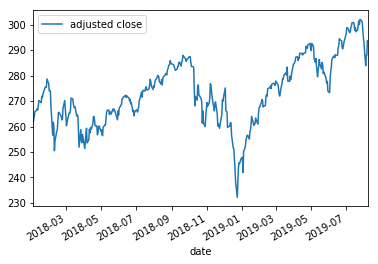

In [10]:
etf_price_ts.plot()

/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


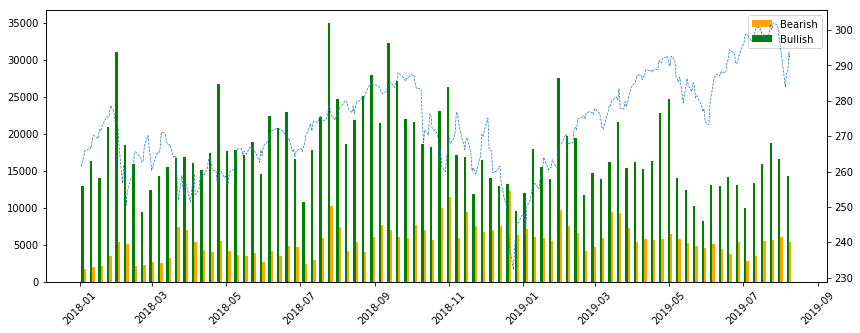

In [11]:
ax = plot_time_series_bar(wkly_sentiment_agg_df[['Bearish', 'Bullish']], 
                          figsize=(14, 5),)

overlay_on_secondary_axis(etf_price_ts, 'adjusted close', ax)

### Daily Correlations by Lag

In [12]:
sentiment_types = [
    'Bullish',
    'Bearish',
    'Bullish_minus_Bearish',
    'Log_Bullish_over_Bearish'
]

In [13]:
# lags indicate Twit leads
n_lags = [0, 1, 3, 5]
corr_summary = []


for sector in all_sectors:
    
    daily_sentiment_agg_df = get_daily_sentiment_agg_df_for_sector(sector)
    etf_ticker = get_etf_ticker_for_sector(sector)
    daily_etf_return = get_nday_returns_for_ticker(etf_ticker, 
                                                   start_date, 
                                                   end_date,
                                                   n_days=1)
    
    daily_sentiment_agg_df = append_sentiment_cols(daily_sentiment_agg_df)
    
    for sentiment_type in sentiment_types:
        for lag in n_lags:
            if lag == 0:
                shifted_daily_sentiment_agg_df = daily_sentiment_agg_df
            else:
                shifted_daily_sentiment_agg_df = shift_date_index(daily_sentiment_agg_df, lag)

            corr = calc_corr(shifted_daily_sentiment_agg_df, 
                             daily_etf_return,
                             sentiment_type,
                             'adjusted close return')
            corr_summary.append({
                'ticker': etf_ticker,
                'sector': sector,
                'sentiment_type': sentiment_type,
                'lag': lag,
                'corr': corr,
            })

number of component tickers 33 in Consumer Staples


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 32 in Real Estate


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 69 in Industrials
number of component tickers 68 in Information Technology
number of component tickers 26 in Communication Services


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 28 in Energy


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 27 in Materials


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 62 in Consumer Discretionary
number of component tickers 67 in Financials


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 62 in Health Care
number of component tickers 28 in Utilities


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 502 in All


In [14]:
corr_summary_df = pd.DataFrame(corr_summary)

In [15]:
corr_summary_df_pivot = corr_summary_df.pivot_table(
    index=['sentiment_type', 'ticker', 'sector'],
    columns=['lag'],
    values='corr'
).round(2)

In [16]:
corr_summary_df_pivot.loc['Log_Bullish_over_Bearish']

,lag,0,1,3,5
ticker,sector,,,,
SPY,All,0.37,-0.00,-0.02,-0.05
XLB,Materials,0.20,0.02,-0.01,-0.10
XLC,Communication Services,0.42,-0.03,-0.09,-0.07
XLE,Energy,0.36,0.07,0.03,-0.05
XLF,Financials,0.34,-0.01,-0.00,-0.08
XLI,Industrials,0.33,0.03,0.01,0.07
XLK,Information Technology,0.33,-0.04,-0.02,-0.07
XLP,Consumer Staples,0.28,0.01,0.02,-0.02
XLRE,Real Estate,0.22,0.01,0.02,-0.02


### Daily vs. NDay Correlation

In [17]:
n_days = [1, 5, 21, 63, 128, 256]
corr_summary = []


for sector in all_sectors:
    
    daily_sentiment_agg_df = get_daily_sentiment_agg_df_for_sector(sector)
    etf_ticker = get_etf_ticker_for_sector(sector)
    
    daily_sentiment_agg_df = append_sentiment_cols(daily_sentiment_agg_df)
    
    for sentiment_type in sentiment_types:
        
        for n_day in n_days:
            nday_etf_return = get_nday_returns_for_ticker(etf_ticker, 
                                                           start_date, 
                                                           end_date,
                                                           n_days=n_day)
            
            shifted_daily_sentiment_agg_df = shift_date_index(daily_sentiment_agg_df, 
                                                              n_day)

            corr = calc_corr(shifted_daily_sentiment_agg_df, 
                             nday_etf_return,
                             sentiment_type,
                             'adjusted close return')
            corr_summary.append({
                'ticker': etf_ticker,
                'sector': sector,
                'sentiment_type': sentiment_type,
                'nday': n_day,
                'corr': corr,
            })

number of component tickers 33 in Consumer Staples


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 32 in Real Estate


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 69 in Industrials
number of component tickers 68 in Information Technology
number of component tickers 26 in Communication Services


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 28 in Energy


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 27 in Materials


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 62 in Consumer Discretionary
number of component tickers 67 in Financials


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 62 in Health Care
number of component tickers 28 in Utilities


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 502 in All


In [18]:
corr_summary_df = pd.DataFrame(corr_summary)

In [19]:
corr_summary_df_pivot = corr_summary_df.pivot_table(
    index=['sentiment_type', 'ticker', 'sector'],
    columns=['nday'],
    values='corr'
).round(2)

In [20]:
corr_summary_df_pivot.loc['Log_Bullish_over_Bearish']

,nday,1,5,21,63,128,256
ticker,sector,,,,,,
SPY,All,-0.00,-0.08,-0.23,-0.34,-0.57,-0.51
XLB,Materials,0.02,-0.08,-0.11,-0.19,-0.34,-0.07
XLC,Communication Services,-0.03,-0.14,-0.32,-0.55,-0.62,-0.19
XLE,Energy,0.07,-0.02,-0.05,0.02,-0.01,-0.05
XLF,Financials,-0.01,-0.07,-0.13,-0.26,-0.43,-0.35
XLI,Industrials,0.03,0.08,0.08,-0.11,-0.34,-0.15
XLK,Information Technology,-0.04,-0.12,-0.23,-0.32,-0.54,-0.44
XLP,Consumer Staples,0.01,-0.04,-0.14,-0.18,-0.32,-0.24
XLRE,Real Estate,0.01,0.07,0.11,-0.01,-0.07,0.01


### Weekly vs NDay Correlation

In [21]:
from util.ts_util import rolling_nday

In [60]:
n_days = [1, 5, 21, 63, 128, 256]
corr_summary = []


for sector in all_sectors:

    daily_sentiment_agg_df = get_daily_sentiment_agg_df_for_sector(sector)
    weekly_sentiment_agg_df = rolling_nday(daily_sentiment_agg_df, window='180D')
    etf_ticker = get_etf_ticker_for_sector(sector)
    
    weekly_sentiment_agg_df = append_sentiment_cols(weekly_sentiment_agg_df)
    
    for sentiment_type in sentiment_types:
        
        for n_day in n_days:
            nday_etf_return = get_nday_returns_for_ticker(etf_ticker, 
                                                           start_date, 
                                                           end_date,
                                                           n_days=n_day)
            
            shifted_weekly_sentiment_agg_df = shift_date_index(weekly_sentiment_agg_df, 
                                                               n_day)

            corr = calc_corr(shifted_weekly_sentiment_agg_df, 
                             nday_etf_return,
                             sentiment_type,
                             'adjusted close return')
            corr_summary.append({
                'ticker': etf_ticker,
                'sector': sector,
                'sentiment_type': sentiment_type,
                'nday': n_day,
                'corr': corr,
            })

number of component tickers 33 in Consumer Staples


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 32 in Real Estate


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 69 in Industrials
number of component tickers 68 in Information Technology
number of component tickers 26 in Communication Services


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 28 in Energy


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 27 in Materials


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 62 in Consumer Discretionary
number of component tickers 67 in Financials


/Users/seung-jae_bang/.virtualenvs/my_research/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


number of component tickers 62 in Health Care
number of component tickers 28 in Utilities
number of component tickers 502 in All


In [61]:
corr_summary_df = pd.DataFrame(corr_summary)

In [62]:
corr_summary_df_pivot = corr_summary_df.pivot_table(
    index=['sentiment_type', 'ticker', 'sector'],
    columns=['nday'],
    values='corr'
).round(2)

In [63]:
corr_summary_df_pivot.loc['Log_Bullish_over_Bearish']

,nday,1,5,21,63,128,256
ticker,sector,,,,,,
SPY,All,-0.03,-0.09,-0.29,-0.38,-0.41,-0.85
XLB,Materials,-0.05,-0.10,-0.21,-0.52,-0.71,0.54
XLC,Communication Services,-0.10,-0.26,-0.52,-0.47,-0.18,-0.79
XLE,Energy,-0.03,-0.09,-0.15,0.07,0.05,-0.09
XLF,Financials,-0.02,-0.07,-0.27,-0.52,-0.58,-0.89
XLI,Industrials,0.00,-0.02,-0.28,-0.48,-0.58,-0.69
XLK,Information Technology,-0.03,-0.09,-0.25,-0.35,-0.58,-0.58
XLP,Consumer Staples,-0.06,-0.15,-0.42,-0.73,-0.71,-0.81
XLRE,Real Estate,-0.01,-0.04,-0.04,-0.28,-0.27,0.70


In [64]:
corr_summary_df_pivot.loc['Log_Bullish_over_Bearish'].median()

nday
1     -0.030
5     -0.090
21    -0.260
63    -0.365
128   -0.350
256   -0.585
dtype: float64

In [97]:
corr_summary = []


for sector in ['Industrials']:

    daily_sentiment_agg_df = get_daily_sentiment_agg_df_for_sector(sector)
    weekly_sentiment_agg_df = resample_weekly(daily_sentiment_agg_df)
    etf_ticker = get_etf_ticker_for_sector(sector)
    
    weekly_sentiment_agg_df = append_sentiment_cols(weekly_sentiment_agg_df)
    
    for sentiment_type in sentiment_types:
        
        
        nday_etf_return = get_nday_returns_for_ticker(etf_ticker, 
                                                       start_date, 
                                                       end_date,
                                                       n_days=5)
        nday_etf_return = nday_etf_return.resample('W-FRI').last()

        shifted_weekly_sentiment_agg_df = weekly_sentiment_agg_df.shift(1)

        corr = calc_corr(shifted_weekly_sentiment_agg_df, 
                         nday_etf_return,
                         sentiment_type,
                         'adjusted close return')
        corr_summary.append({
            'ticker': etf_ticker,
            'sector': sector,
            'sentiment_type': sentiment_type,
#             'nday': n_day,
            'corr': corr,
        })

number of component tickers 69 in Industrials


In [102]:
daily_sentiment_agg_df.std()

Bearish    136.847687
Bullish    129.430918
dtype: float64

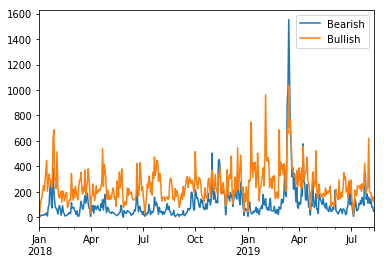

In [103]:
daily_sentiment_agg_df.plot()

In [88]:
corr_summary_df = pd.DataFrame(corr_summary)

In [90]:
corr_summary_df = corr_summary_df[corr_summary_df['sentiment_type'] == 'Log_Bullish_over_Bearish']

In [94]:
corr_summary_df.drop('sentiment_type', axis=1).sort_values('corr').round(2)

,corr,sector,ticker
19,-0.30,Communication Services,XLC
31,-0.15,Consumer Discretionary,XLY
23,-0.14,Energy,XLE
27,-0.13,Materials,XLB
47,-0.12,All,SPY
15,-0.11,Information Technology,XLK
39,-0.11,Health Care,XLV
35,-0.10,Financials,XLF
3,-0.09,Consumer Staples,XLP
7,-0.00,Real Estate,XLRE


In [96]:
sector

'All'

In [95]:
daily_sentiment_agg_df

,Bearish,Bullish
2018-01-01,14.0,159.0
2018-01-02,180.0,2217.0
2018-01-03,509.0,3889.0
2018-01-04,668.0,3418.0
2018-01-05,472.0,3238.0
2018-01-08,387.0,3796.0
2018-01-09,442.0,2941.0
2018-01-10,395.0,2655.0
2018-01-11,307.0,2767.0
2018-01-12,563.0,4224.0
